# Solving a 1st-order ODE IVP with a neural network

## Setup

In [1]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [2]:
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to use the code in the `nnode1.py` module. The module allows the user to solve 1st-order ordinary differential equation (ODE) initial value problems (IVPs) using a single-hidden layer neural network.

This work is based on the paper ["Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998](http://ieeexplore.ieee.org/document/712178/). Note that the notation used in this notebook and the associated Python code differs slightly from that used in the Lagaris paper.

## The algorithm

Any 1st-order ODE can be written in the form:

\begin{equation}
G\left(x,y,\frac {dy}{dx}\right) = 0
\end{equation}

The problem is to find a solution $y(x)$ to the ODE using a neural network, subject to the initial condition:

\begin{equation}
y(0) = A
\end{equation}

The network is trained using a set of *training points* $x_i$ ($1 \le i \le n$), defined on the domain of interest. The training points need not be evenly-spaced. Note that only the independent variable values $x_i$ of the training points are needed - the estimated value of the solution at those training points is obtained using a trial solution. Such an ODE can always be scaled and mapped onto the domain $[0,1]$, and this code assumes such mapping has already been performed. For 1st-order ODE IVP, the trial solution has the form:

\begin{equation}
y_t(x_i) = A(x_i) + P(x_i)N(x_i,\vec p)
\end{equation}

For 1st-order ODE IVP, the forms for $A(x_i)$ and $P(x_i)$ are particularly simple:

\begin{equation}
A(x_i)=A
\end{equation}

\begin{equation}
P(x_i)=x_i
\end{equation}

The trial solution can be written more compactly as:

\begin{equation}
y_{ti} = A + x_i N_i
\end{equation}

where $y_{ti}=y_t(x_i,\vec p)$ is the value of the trial solution at the current training point $x_i$, and $N_i=N(x_i,\vec p)$ is the single-valued floating-point output from an unspecified neural network with parameters $\vec p$. Note that this trial solution satisfies the initial condition by construction - at $x=0$, the second term vanishes, leaving $y_t(0)=A$.

Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $x_i$, one at a time. For each input value $x_i$, the network output $N_i$ is computed, and used to compute the value of the trial solution $y_{ti}$. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. The ODE definition (1) should vanish at convergence, and so an appropriate form for the error function is:

\begin{equation}
E = \sum_{j=1}^{n}G_i^2
\end{equation}

where $G_i$ is:

\begin{equation}
G_i = G\left(x_i,y_{ti},\frac {\partial y_{ti}}{\partial x_i}\right)
\end{equation}

where $\frac {\partial y_{ti}}{\partial x_i}$ is the derivative of the trial function with respect to $x$, evaluated at $x_i$. This derivative is the current approximation of the analytical derivative $\frac {dy}{dx}$. Once this error function is computed, the weights and biases in the neural network are adjusted to reduce the error. Eventually, a minimum of $E$ is attained, and the resulting final form of $y_t(x)$ is used as the solution to the original ODE.

## Computing the network output $N_i$

The neural network used in this work has a simple structure. A single input node is used to provide the training data. The input node is fully-connected to a set of $H$ hidden nodes. Each hidden node is connected to a single output node.

During each step of a training epoch, the input to the network, and thus the output of the single input node, is just the training point $x_i$. This single output is then sent to each of the $H$ hidden nodes. At each hidden node $k$, the input value $x_i$ is transformed by the equation:

\begin{equation}
z_{ik} = w_k x_i + u_k
\end{equation}

where $z_{ik}$ is the transformed input at hidden node $k$, $w_k$ is the weight at node $k$, and $u_k$ is the bias at node $k$. This transformed value is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ik} = \sigma(z_{ik})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first several derivatives is provided below.

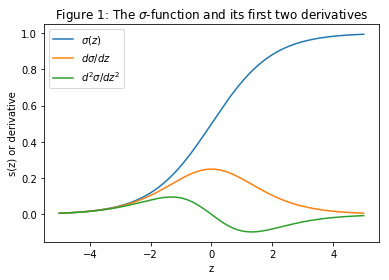

In [3]:
def sigma(z):
    return 1 / (1 + exp(-z))

def dsigma_dz(z):
    return exp(-z) / (1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2 * exp(-2 * z) / (1 + exp(-z))**3 - exp(-z) / (1 + exp(-z))**2
    )

z = np.linspace(-5, 5, 1001)
n = len(z)
s = np.zeros(n)
ds_dz = np.zeros(n)
d2s_dz2 = np.zeros(n)
for i in range(n):
    s[i] = sigma(z[i])
    ds_dz[i] = dsigma_dz(z[i])
    d2s_dz2[i] = d2sigma_dz2(z[i])
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,ds_dz,label = "$d\sigma/dz$")
plt.plot(z,d2s_dz2, label = "$d^2\sigma/dz^2$")
plt.xlabel("z")
plt.ylabel("s(z) or derivative")
plt.title("Figure 1: The $\sigma$-function and its first two derivatives")
plt.legend();

Once the $\sigma_{ik}$ are computed, they are all passed to the single output node, where they are summed by a linear transfer function to create the network output for the current value of $x_i$:

\begin{equation}
N_i = \sum_{k=1}^{H}v_k\sigma_{ik}
\end{equation}

where $v_k$ is the weight applied to the signal from hidden node $k$ at the output node. Once $N_i$ has been computed, the trial function $y_{ti}$ and its derivative $\frac {\partial y_{ti}}{\partial x_i}$ is computed, and then the value of the ODE $G_i$ is computed, and finally the error function $E$.

## Updating the network parameters

The network parameters are the weights and biases of the hidden and output nodes. For a set of $H$ hidden nodes, we have a total of $N_p = 3H$ parameters in total: a weight and bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p$ (where $p$ represents $v_k$, $u_k$, or $w_k$) is updated using a scaled, simplified Newton's method:

\begin{equation}
p_{new} = p - \eta \frac {\partial E}{\partial p}
\end{equation}

where $\eta$ is the *learning rate* (usually $\eta < 1$). This simplified method (ignoring the usual 2nd derivative in the denominator of the correction term) is appropriate when the problem is scaled to the domain $[0,1]$.The learning rate is used to reduce the chance of solution instability due to large values of the correction term. The derivatives of $E$ are computed using the known form of the network and internal parameters.

This process of parameter updates is repeated until convergence is achieved (an error minimum is reached), or until the specified maximum number of training epochs have been applied. Note that the same set of training points is presented during each epoch.

## Computing the derivatives of $E$

The partial derivative of $E$ with respect to any network parameter $p$ is given by:

\begin{equation}
\frac {\partial E}{\partial p} =
\frac {\partial}{\partial p} \sum_{i=1}^{n}G_i^2 =
2 \sum_{i=1}^n G_i \frac {\partial G_i}{\partial p}
\end{equation}

## Computing the derivatives of $G_i$

The partial derivative of $G_i$ with respect to any network parameter $p$ is computed using the chain rule:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial}{\partial p} G\left(x_i,y_{ti},\frac {\partial y_{ti}}{\partial x_i}\right) =
\sum_{i=1}^n \left ( \frac {\partial G_i}{\partial x_i} \frac {\partial x_i}{\partial p} \right ) +
\frac {\partial G_i}{\partial y_{ti}} \frac {\partial y_{ti}}{\partial x_i} +
\sum_{i=1}^n \frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}} \frac {\partial^2 y_{ti}}{\partial p \partial x_i}
\end{equation}

Since the training points $x_i$ are independent of the network parameters $\vec p$, this equation simplifies to:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial G_i}{\partial y_{ti}} \frac {\partial y_{ti}}{\partial x_i} +
\sum_{i=1}^n \frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}} \frac {\partial^2 y_{ti}}{\partial p \partial x_i}
\end{equation}

The analytical forms of $\frac {\partial G_i}{\partial y_{ti}}$ and $\frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}}$ are determined from the analytical form of the original ODE.

## Computing the derivatives of $y_{ti}$

The generic form of the derivatives of $y_{ti}$ is:

\begin{equation}
\frac {\partial y_{ti}}{\partial x_i} =
\frac {\partial A_i}{\partial x_i} +
P_i \frac {\partial N_i}{\partial x_i} + \frac {\partial P_i}{\partial x_i} N_i
\end{equation}

In the current case, $A_i$ is constant, and $P_i=x_i$, so we are left with:

\begin{equation}
\frac {\partial y_{ti}}{\partial x_i} =
x_i \frac {\partial N_i}{\partial x_i} + N_i
\end{equation}

The cross partial of $y_{ti}$ is then:

\begin{equation}
\frac {\partial^2 y_{ti}}{\partial p \partial x_i} =
x_i \frac {\partial^2 N_i}{\partial p \partial x_i} + \frac {\partial N_i}{\partial p}
\end{equation}

## Computing the derivatives of $N_i$

The generic form of the derivative of $N_i$ with respect to $x_i$ is:

\begin{equation}
\frac {\partial N_i}{\partial x_i} =
\frac {\partial}{\partial x_i} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial z_{ik}} \frac {\partial z_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k
\end{equation}

where the transfer function derivatives are defined by:

\begin{equation}
\sigma^{(n)} = \frac {\partial^n \sigma}{\partial z^n}
\end{equation}

For the parameter derivatives:

\begin{equation}
\frac {\partial N_i}{\partial p} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H \left ( v_k \frac {\partial \sigma_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right )
\end{equation}

For the cross-partials:

\begin{equation}
\frac {\partial^2 N_i}{\partial p \partial x_i} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_k}{\partial p} +
v_k \frac {\partial \sigma_{ik}^{(1)}}{\partial p}  w_k +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_k \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_k}{\partial p} +
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}}{\partial p}  w_k +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_k \right )
\end{equation}

## Computing the derivatives of $z_{ik}$

The derivatives of $z_k$ with respect to the network parameter $p$ are parameter-specific:

\begin{equation}
\frac {\partial z_{il}}{\partial v_k} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial u_k} = \delta_{kl}
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial w_k} = x_i \delta_{kl}
\end{equation}

## Computing the derivatives of the parameters $\vec p$

At this lowest level, the parameter derivatives are simple in form:

\begin{equation}
\frac {\partial v_l}{\partial v_k} = \delta_{kl}, \frac {\partial v_l}{\partial u_k} = 0, \frac {\partial v_l}{\partial w_k} = 0
\end{equation}

\begin{equation}
\frac {\partial u_l}{\partial v_k} = 0, \frac {\partial u_l}{\partial u_k} = \delta_{kl}, \frac {\partial u_l}{\partial w_k} = 0
\end{equation}

\begin{equation}
\frac {\partial w_l}{\partial v_k} = 0, \frac {\partial w_l}{\partial u_k} = 0, \frac {\partial w_l}{\partial w_k} = \delta_{kl}
\end{equation}

Or, more succinctly:

\begin{equation}
\frac {\partial p_l}{\partial p_k} = \delta_{kl}
\end{equation}

# Walking through an example problem

We will now walk through a complete problem which will illustrate how to use the `nnode1` code to solve a 1st-order ODE IVP.

## Define the ODE to solve, and the initial condition

Consider the simple 1st-order ODE IVP, defined on the domain $[0,1]$:

\begin{equation}
G\left(x,y,\frac {dy}{dx}\right) = x-y = 0
\end{equation}

The analytical solution to this equation is simply:

\begin{equation}
y(x) = x
\end{equation}

This analytical solution and its derivative are shown in the figure below.

In [4]:
def ya(x):
    return x

def dya_dx(x):
    return 1

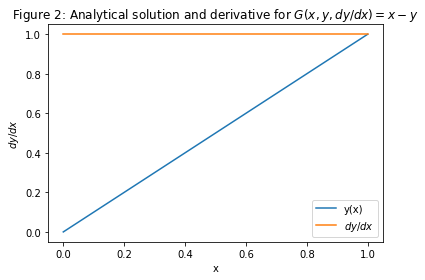

In [5]:
xmin = 0
xmax = 1
n = 100
x = np.linspace(xmin, xmax, n)
y = np.zeros(n)
dy_dx = np.zeros(n)
for i in range(n):
    y[i] = ya(x[i])
    dy_dx[i] = dya_dx(x[i])
plt.xlabel('x')
plt.ylabel('$dy/dx$')
plt.plot(x, y, label = 'y(x)')
plt.plot(x, dy_dx, label = "$dy/dx$")
plt.legend()
plt.title("Figure 2: Analytical solution and derivative for $G(x,y,dy/dx)=x-y$");

Define the differential equation itself, and its derivatives.

In [6]:
# Define the original differential equation:
def G(x, y, dy_dx):
    return x - y

# Define the y-partial derivative of the differential equation.
def dG_dy(x, y, dy_dx):
    return -1

# Define the dy/dx-partial derivative of the differential equation.
def dG_dydx(x, y, dy_dx):
    return 0

The initial condition is:

In [7]:
A = 0

## Create the training data

For the purposes of this example, an evenly-spaced set of training points will be used to train the neural network.

In [8]:
nt = 10
xt = np.linspace(xmin, xmax, num = nt)

Note that repeated runs of the same ODE will usually result in slightly different solutions, due to the random number generator. To ensure repeatable results, seed the random number generator with a fixed value before each run.

## Train the model to solve the ODE

We can now train the network. The call below shows the minimum arguments required to call the `nnode1()` function. All tunable parameters (learning rate `eta`, hidden layer size `H`, number of training epochs `max_epochs` are given default values (`0.01`, `10`, `1000`, respectively). The training function returns the estimated values of $y$ and $\frac {dy}{dx}$ at the training points. When the `verbose` option is set to `True`, the function prints out the epoch number and current value of the mean-squared error of $G_i$.

In [9]:
from nnode1 import nnode1
np.random.seed(0)
(yt, dyt_dx) = nnode1(G, A, dG_dy, dG_dydx, xt, verbose = True)

0 1.269505845916997
1 0.9344695935940753
2 0.6899975355257151
3 0.511367185802461
4 0.3810145685913241
5 0.2863315991467354
6 0.2182050159011167
7 0.16998738943233577
8 0.1367281019034418
9 0.11459082316222512
10 0.10047188089170121
11 0.09184664438490041
12 0.08676594769589224
13 0.0838492195654002
14 0.08219890571368628
15 0.08126896821807984
16 0.08074168345457977
17 0.08043716582946149
18 0.080255181865986
19 0.08014038299106885
20 0.08006235907002869
21 0.08000444800986138
22 0.07995753422586906
23 0.07991663481017999
24 0.07987902713327602
25 0.07984322392055095
26 0.0798084128286349
27 0.07977415018657467
28 0.07974019368469157
29 0.0797064109866754
30 0.0796727298164668
31 0.07963911069855915
32 0.0796055320706258
33 0.0795719821531456
34 0.07953845450921343
35 0.07950494561965042
36 0.07947145355871466
37 0.07943797727087615
38 0.07940451617584597
39 0.07937106995287439
40 0.07933763842295168
41 0.0793042214844751
42 0.07927081907811626
43 0.07923743116763544
44 0.079204057729

490 0.06564700818002885
491 0.06561935929819332
492 0.06559172179198856
493 0.06556409565585515
494 0.06553648088423736
495 0.06550887747158522
496 0.06548128541235221
497 0.06545370470099834
498 0.06542613533198668
499 0.06539857729978536
500 0.06537103059886765
501 0.06534349522371155
502 0.06531597116879892
503 0.06528845842861776
504 0.06526095699765852
505 0.06523346687041896
506 0.06520598804139927
507 0.06517852050510528
508 0.06515106425604743
509 0.06512361928874057
510 0.06509618559770491
511 0.06506876317746398
512 0.06504135202254684
513 0.0650139521274869
514 0.06498656348682216
515 0.06495918609509548
516 0.06493181994685403
517 0.06490446503664948
518 0.06487712135903838
519 0.06484978890858172
520 0.06482246767984505
521 0.06479515766739852
522 0.06476785886581667
523 0.06474057126967865
524 0.06471329487356861
525 0.06468602967207399
526 0.0646587756597892
527 0.06463153283131004
528 0.0646043011812391
529 0.06457708070418246
530 0.064549871394751
531 0.064522673247560

899 0.05522972002716605
900 0.05520630698866406
901 0.05518290338488224
902 0.05515950921176248
903 0.05513612446524927
904 0.05511274914129093
905 0.05508938323583744
906 0.055066026744842476
907 0.05504267966426162
908 0.055019341990054406
909 0.0549960137181822
910 0.054972694844609316
911 0.05494938536530299
912 0.05492608527623334
913 0.05490279457337275
914 0.054879513252697215
915 0.05485624131018449
916 0.054832978741816286
917 0.0548097255435754
918 0.054786481711449446
919 0.0547632472414269
920 0.05474002212950048
921 0.05471680637166426
922 0.05469359996391634
923 0.05467040290225644
924 0.05464721518268787
925 0.0546240368012159
926 0.0546008677538494
927 0.0545777080365996
928 0.05455455764547999
929 0.05453141657650726
930 0.05450828482570067
931 0.054485162389082756
932 0.05446204926267735
933 0.054438945442512154
934 0.05441585092461749
935 0.05439276570502604
936 0.05436968977977336
937 0.05434662314489746
938 0.05432356579643887
939 0.05430051773044168
940 0.05427747

Plot the results of this training run.

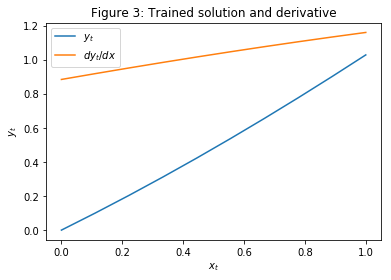

In [10]:
plt.plot(xt, yt, label = '$y_t$')
plt.plot(xt, dyt_dx, label = '$dy_t/dx$')
plt.xlabel('$x_t$')
plt.ylabel('$y_t$')
plt.legend()
plt.title("Figure 3: Trained solution and derivative");

Plot the error in the estimated solution and derivatives.

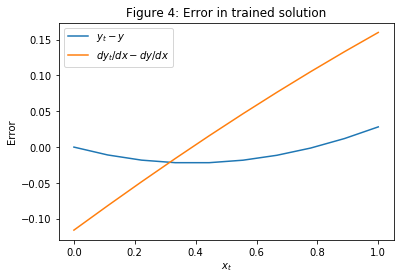

In [11]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 4: Error in trained solution");

Now try repeating the analysis with a larger number of hidden nodes, and plot the error.

In [12]:
np.random.seed(0)
(yt, dyt_dx) = nnode1(G, A, dG_dy, dG_dydx, xt, nhid = 20)

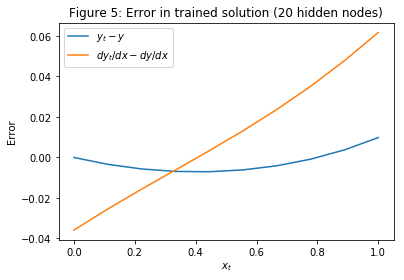

In [13]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 5: Error in trained solution (20 hidden nodes)");

Now try repeating the analysis with a slightly larger learning rate, and plot the error.

In [14]:
np.random.seed(0)
(yt, dyt_dx) = nnode1(G, A, dG_dy, dG_dydx, xt, nhid = 20, eta = 0.02)

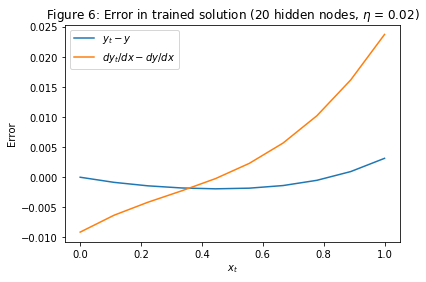

In [15]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 6: Error in trained solution (20 hidden nodes, $\eta$ = 0.02)");

Now try repeating the analysis with a larger number of training epochs, and plot the error.

In [16]:
np.random.seed(0)
(yt, dyt_dx) = nnode1(G, A, dG_dy, dG_dydx, xt, nhid = 20, eta = 0.02, maxepochs = 2000)

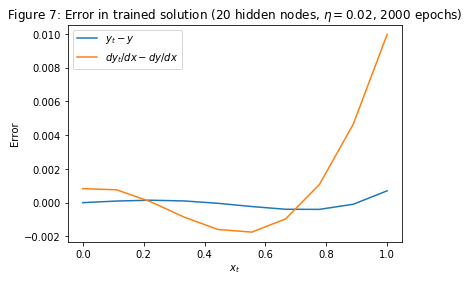

In [17]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 7: Error in trained solution (20 hidden nodes, $\eta=0.02$, 2000 epochs)");

## Using a ODE definition module

Rather than entering ODE definitions in this notebook, the required definitions can be entered in a separate Python module, and imported. For example, the previous code is also encapsulated in the file `ode00.py`, and can be imported:

In [18]:
import ode00

We can now run the net using the information in this module.

In [19]:
np.random.seed(0)
(yt, dyt_dx) = nnode1(ode00.Gf, ode00.ic, ode00.dG_dyf, ode00.dG_dydxf, xt)

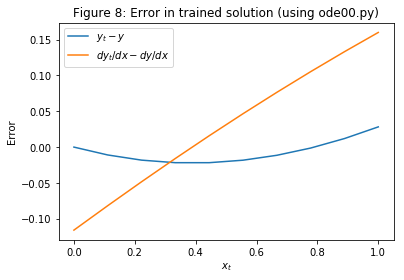

In [20]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ode00.yaf(xt[i])
    dy_dx[i] = ode00.dya_dxf(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 8: Error in trained solution (using ode00.py)");